In [1]:
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle
import sys
from json import loads

sys.path.append("../code/python/utils")
from pool_iterator import pool_iterator
from metric import calculate_metric
from json_tools import get_from_pool
sys.path.append("../code/python/bandits")
from tomson_bandit import TomsonBandit
from cascade_bandit import CascadeBandit
from damerau_levenshtien import damerau_levenshtein_distance

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
n_objects = 569105

In [3]:
queries_counter = pickle.load(open("queries_counter", "rb"))
queries_by_word = pickle.load(open("queries_by_word", "rb"))

In [4]:
len(queries_counter)

459862

In [5]:
def parse_query(string):
    return tuple(map(int, string[1:-1].split(", ")))

In [6]:
%%time

nearest_queries = {}

with open("../code/python/bandits/nearest_queries.txt") as handler:
    for i, line in enumerate(handler):
        parsed_line = loads(("{" + line.strip() + "}").replace('(', '"(').replace(')', ')"'))
        query_str = line[:line.find(":")]
        nearest_queries[parse_query(query_str)] = [
            parse_query(other_query)
            for other_query in parsed_line[query_str]
        ]

CPU times: user 4.75 s, sys: 90.4 ms, total: 4.84 s
Wall time: 4.8 s


In [12]:
%%time
position_variants = list(range(10)) + [100]
bandits_by_queries = {
    query: TomsonBandit(position_variants) for query in queries_counter
}
big_bandit = CascadeBandit(bandits_by_queries, nearest_queries)

CPU times: user 3.1 s, sys: 170 ms, total: 3.27 s
Wall time: 3.27 s


In [8]:
pool_filenames = [
    "pool_with_queries/train_test_split/day_{}.json".format(i)
    for i in range(4)
]
train_pool_filenames = pool_filenames[:3]
test_pool = pool_filenames[3]

In [13]:
%%time
for pool_filename in train_pool_filenames:
    print(" fitting filename \"{}\"".format(pool_filename))
    for i, item in enumerate(pool_iterator(pool_filename)):
        if i % 10000 == 0:
            print(" {} %".format(round(400 * i / n_objects)))
        query = tuple(map(int, item["query"].split()))
        reward = 1 if item["target"] > 0 else 0
        big_bandit.take_reward(query, item["pos"], reward)

 fitting filename "pool_with_queries/train_test_split/day_0.json"
 0 %
 7 %
 14 %
 21 %
 28 %
 35 %
 42 %
 49 %
 56 %
 63 %
 70 %
 77 %
 84 %
 91 %
 98 %
 fitting filename "pool_with_queries/train_test_split/day_1.json"
 0 %
 7 %
 14 %
 21 %
 28 %
 35 %
 42 %
 49 %
 56 %
 63 %
 70 %
 77 %
 84 %
 91 %
 98 %
 fitting filename "pool_with_queries/train_test_split/day_2.json"
 0 %
 7 %
 14 %
 21 %
 28 %
 35 %
 42 %
 49 %
 56 %
 63 %
 70 %
 77 %
 84 %
 91 %
 98 %
CPU times: user 2min 6s, sys: 2.36 s, total: 2min 8s
Wall time: 2min 14s


In [10]:
%%time
targets_test = get_from_pool(pool_iterator(test_pool), "target", int)
probas_test = get_from_pool(pool_iterator(test_pool), "p", float)
positions_test = get_from_pool(pool_iterator(test_pool), "pos", int)

CPU times: user 2min 2s, sys: 1.5 s, total: 2min 4s
Wall time: 2min 6s


In [76]:
%%time
answer_positions = []
statistics = []
for i, item in enumerate(pool_iterator(test_pool)):
    if i % 10000 == 0:
        print(" {} %".format(round(i * 100 / len(positions_test))))
    query = tuple(map(int, item["query"].split()))
    statistics.append(big_bandit.get_statistic_size(query))
    answer_positions.append(big_bandit.get_action(query))

 0 %
 7 %
 14 %
 21 %
 28 %
 35 %
 42 %
 49 %
 56 %
 63 %
 70 %
 77 %
 84 %
 91 %
 98 %
CPU times: user 50.8 s, sys: 716 ms, total: 51.5 s
Wall time: 51.9 s


In [77]:
answer_positions = np.array(answer_positions)
statistics = np.array(statistics)

In [78]:
def compute_metric(threshold):
    mask = (positions_test == answer_positions) * (statistics > threshold)
    return np.sum(targets_test[mask] / probas_test[mask]) / np.sum(1 / probas_test[mask])

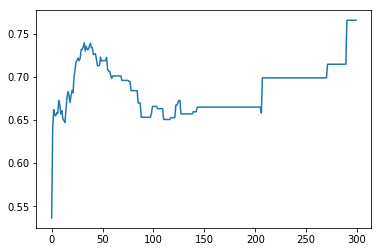

In [79]:
x = np.arange(max(statistics))
y = np.array([
    compute_metric(threshold)
    for threshold in x
])
plt.plot(x[:300], y[:300])

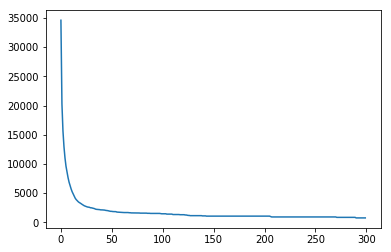

In [80]:
x = np.arange(max(statistics))
y = np.array([
    len(statistics[statistics > threshold])
    for threshold in x
])
plt.plot(x[:300], y[:300])

In [81]:
def caompute_all_metric(threshold):
    tmp_answer = np.copy(answer_positions)
    tmp_answer[statistics < threshold] = 8
    return calculate_metric(
        tmp_answer,
        positions_test,
        targets_test,
        probas_test
    )

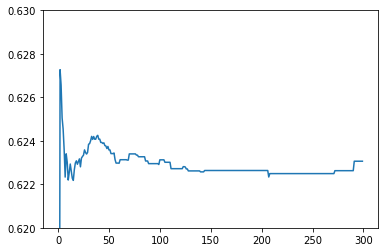

In [86]:
axis = plt.gca()
x = np.arange(max(statistics))
y = np.array([
    caompute_all_metric(threshold)
    for threshold in x
])
plt.plot(x[:300], y[:300])
axis.set_ylim(0.62, 0.63)
plt.show()

In [31]:
for i in list(range(10)) + [100]:
    print(' ', i, calculate_metric(
        [i] * len(probas_test),
        positions_test,
        targets_test,
        probas_test
    ))

  0 0.597785108388313
  1 0.6099456748850818
  2 0.612070331062886
  3 0.6208130328867236
  4 0.6088980858768753
  5 0.6147480419683761
  6 0.6207842854047808
  7 0.6103868347937592
  8 0.6226212619831162
  9 0.6197430316646771
  100 0.5989450003878676
